# Entitity Detection and Graph Visualization


In [1]:
## Importing necessary libraries 
import pandas as pd
import numpy as np 
import spacy 
from spacy import displacy
import networkx as nx
from pyvis.network import Network
import matplotlib.pyplot as plt
from  matplotlib.ticker import FuncFormatter
import seaborn as sns
import community as community_louvain
import os
import re

In [2]:
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

## Loading Spacy Pipeline and Dataset

Using Spacy we are able to detect entities within the book. We are using an NLP technique called entity extraction. We are pulling out specific data by classifying text into predefined categories. These catergories exist within the spacy pipline.

In [3]:
!python -m spacy download en_core_web_sm

     ---------------------------------------- 12.8/12.8 MB 8.7 MB/s eta 0:00:00
[+] Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [4]:
## Loading spacy Language Model
NER = spacy.load('en_core_web_sm')

In [5]:
ruler = NER.add_pipe('entity_ruler',after="ner")
ruler.add_patterns([{"label": "Person", "pattern": 'Mayor'}])

In [6]:
## loading books in chronological order
books = [b for b in os.scandir('Books') if '.txt' in b.name]
books.sort(key = lambda x: x.name)

In [7]:
#Loaded book into our spacy pipeline and identifying entities
opened_books = [NER(open(book, encoding='utf-8').read()) for book in books]

## Visual display of entity detection 
displacy.render(opened_books[0][300:2000], style = 'ent', jupyter = True)

In [8]:
##Importing scrapped character dataset
characters_df = pd.read_csv('characters.csv', index_col = 0)
##Adding a custom entity 'Mayor' to our Language pipline as it will not detect 'Mayor' as a person

characters_df = characters_df.replace('David Prentiss', 'Mayor')

## Function to filter out only characers names entities from our characters dataframe
def character_entities(entities, characters_df):
    return [ent for ent in entities 
           if ent in characters_df['Names'].unique()
           or ent in characters_df['First Name'].unique()]

## XDA (Network Data Analysis)
1) We search through each sentence of the books and collect all entitites in each sentence. We store each sentence and existing entities in a dataframe

2) Using our character_entitites function we are able to filter out only entities that exist within our characters dataframe

3) We performed a rolling window of 5 sentences that iterates through the entirety of the entitity dataframe. Characters entities within the rolling window are then estabilished as a relationship and we append that to our connections dataframe. We make sure to not add duplicate relationships in the same rolling window as it will affect the weight of the edges. We then group the dataframe by distict relationships and count the the occurence of each relationship. That value will be the weight of the edge.

4) Using networkx and pyviz, we are able to visualize a graph given our connections dataframe. We are also able to calculate the degree centralitiy which is a number that determines how important a node is in our graph

In [9]:

book_graphs = []
degree_centrality_dfs = []

for book in opened_books:
    sent_entity_df = []
    for sentence in book.sents:
        entity_list = [ent.text for ent in sentence.ents]
        sent_entity_df.append({'Sentence': sentence, 'Entities': entity_list})
     
    sent_entity_df = pd.DataFrame(sent_entity_df)
    
    sent_entity_df['Character Entities'] = sent_entity_df['Entities'].apply(lambda x: character_entities(x, characters_df))
    sent_entity_df['Character Entities'] = sent_entity_df['Character Entities'].apply(lambda x: [char.split()[0] for char in x])
    sent_entity_df = sent_entity_df[sent_entity_df['Character Entities'].map(len) > 0]
    
    window_size = 5
    connections = []
    for i in range(sent_entity_df.index[-1]):
        window_edge = min(i + window_size, sent_entity_df.index[-1])
        character_list = sum((sent_entity_df.loc[i:window_edge]['Character Entities']), [])
    
        distinct_list = list(set(character_list))
    
        if len(distinct_list) > 1:
            for index, char1 in enumerate(distinct_list[:-1]):
                char2 = distinct_list[index + 1]
                connections.append({'Primary': char1, 'Secondary' : char2})
    connections_df = pd.DataFrame(connections)
    
    
    
    
    connections_df = pd.DataFrame(np.sort(connections_df.values, axis = 1), columns = connections_df.columns)
    connections_df['value'] = 1
    connections_df = connections_df.groupby(['Primary', 'Secondary'], as_index = False).sum()

    graph = nx.from_pandas_edgelist(connections_df, source = 'Primary', target = 'Secondary', edge_attr = 'value')
    
    book_graphs.append(graph)
    
    degree_dict = nx.degree_centrality(graph)
    degree_df = pd.DataFrame.from_dict(degree_dict, orient = 'index', columns = ['centrality'])
    degree_centrality_dfs.append(degree_df)

We can see that Todd, Viola and Mayor are the 3 most important characters

array([<AxesSubplot: title={'center': 'centrality'}>], dtype=object)

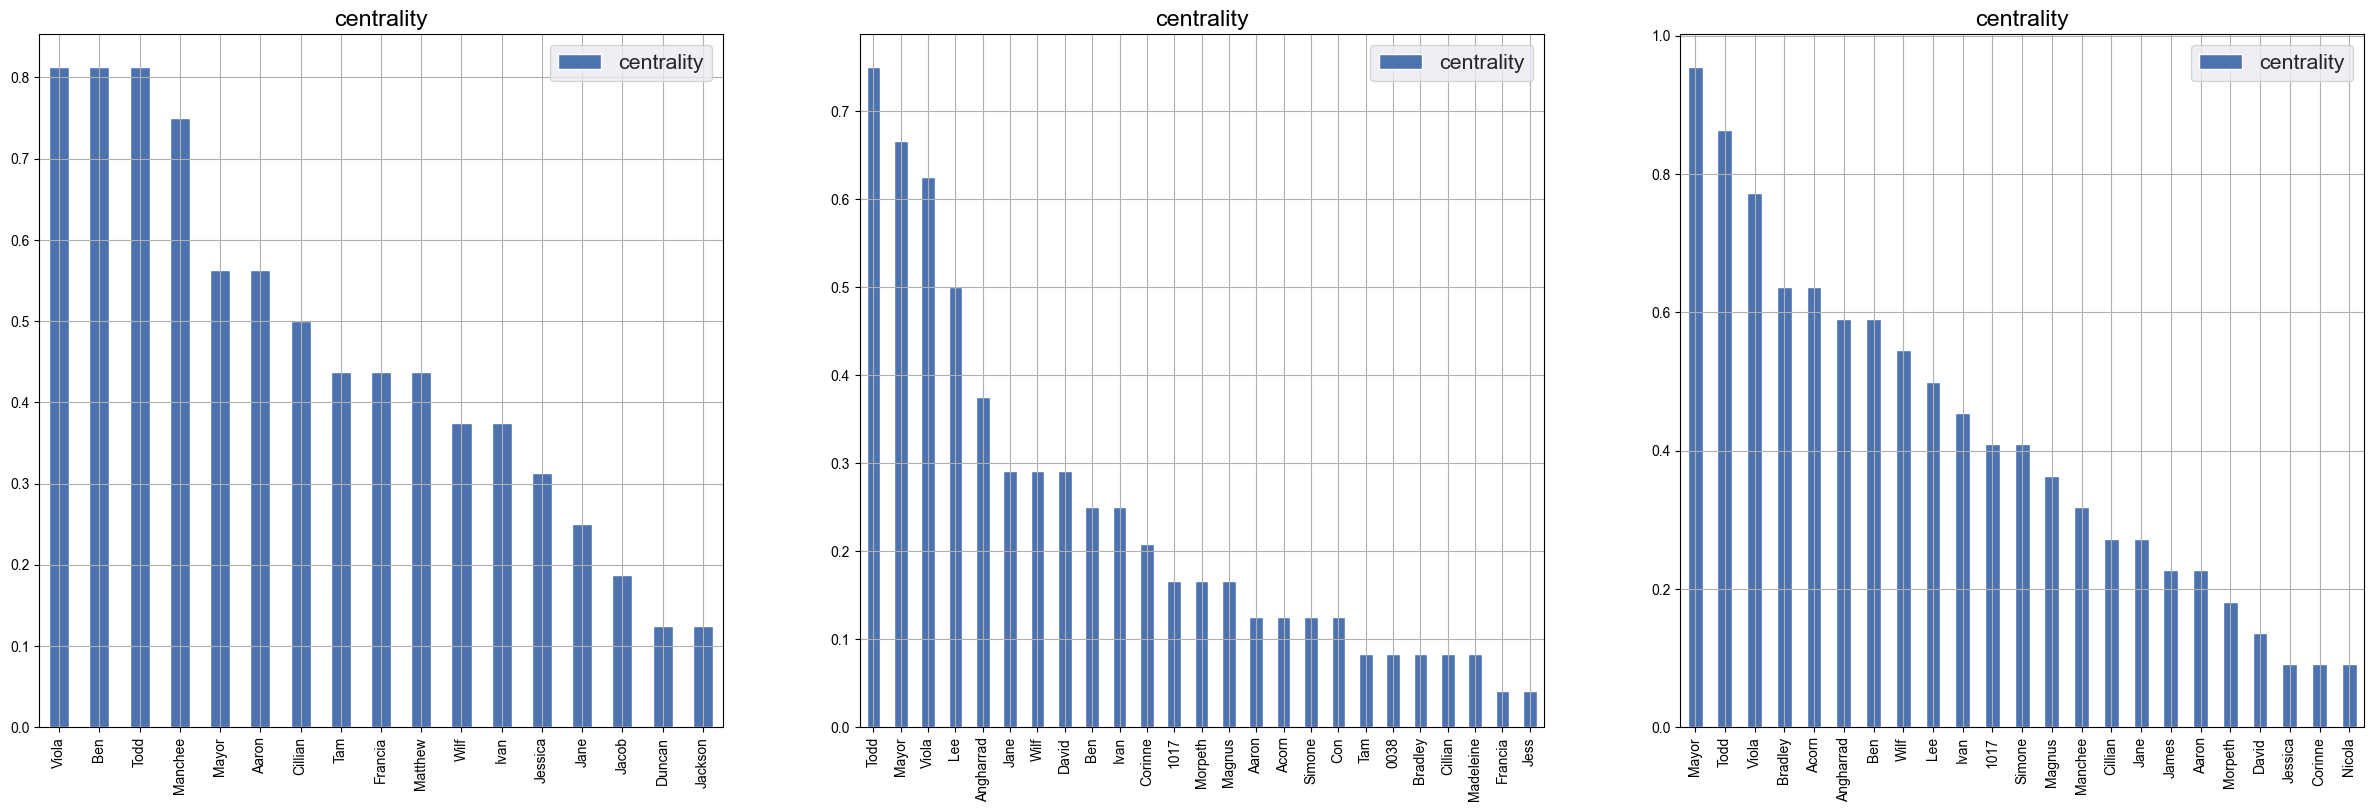

In [10]:
## Graphing degree centralities through out the series
fig, axes = plt.subplots(nrows=1,ncols=3)
sns.set(font_scale = 1.4)
fig.set_size_inches(30, 9)
degree_centrality_dfs[0].sort_values('centrality', ascending = False).plot(kind = 'bar', ax = axes[0], subplots=True)
degree_centrality_dfs[1].sort_values('centrality', ascending = False).plot(kind = 'bar', ax = axes[1], subplots=True)
degree_centrality_dfs[2].sort_values('centrality', ascending = False).plot(kind = 'bar', ax = axes[2], subplots=True)


In [11]:
## Saving Graphs as an html
i = 1

for graph in book_graphs:
    net = Network(notebook = True, width = '1000px', height = '1000px', bgcolor = 'white', font_color = 'black')
    nx.set_node_attributes(graph, dict(graph.degree), 'size')
    net.from_nx(graph)
    net.show(str(i)+'chaos.html' )
    i += 1


Local cdn resources have problems on chrome/safari when used in jupyter-notebook. 
Local cdn resources have problems on chrome/safari when used in jupyter-notebook. 
Local cdn resources have problems on chrome/safari when used in jupyter-notebook. 


## Applying Louvains Community Detection Algorithm 
1) Using the community detection library, we are able to use Louvains Community Detection Algorithm to detect different communities

In [12]:

i = 1
for graph in book_graphs:
    net = Network(notebook = True, width = '1000px', height = '1000px', bgcolor = 'white', font_color = 'black')
    partition = community_louvain.best_partition(graph)
    nx.set_node_attributes(graph, partition, 'group')
    net.show_buttons(filter_=['physics'])
    net.from_nx(graph)
    net.show(str(i)+'chaos-communities.html')
    i += 1
   
net = Network(notebook = True, width = '1000px', height = '1000px', bgcolor = 'white', font_color = 'black')
partition = community_louvain.best_partition(book_graphs[0])
nx.set_node_attributes(book_graphs[0], partition, 'group')
net.show_buttons(filter_=['physics'])
net.from_nx(book_graphs[0])
net.show(str(1)+'chaos-communities.html')

Local cdn resources have problems on chrome/safari when used in jupyter-notebook. 
Local cdn resources have problems on chrome/safari when used in jupyter-notebook. 
Local cdn resources have problems on chrome/safari when used in jupyter-notebook. 
Local cdn resources have problems on chrome/safari when used in jupyter-notebook. 


In [13]:
## Recording Degree Centralitiy of each character through out the series in a dataframe
evol = [nx.degree_centrality(book) for book in book_graphs]
degree_evol_df = pd.DataFrame(evol)
degree_evol_df

,Aaron,Ben,Cillian,Jane,Manchee,Mayor,Tam,Todd,Viola,Wilf,...,Morpeth,Bradley,Simone,Con,Corinne,Magnus,Jess,Madeleine,James,Nicola
0,0.562500,0.812500,0.500000,0.250000,0.750000,0.562500,0.437500,0.812500,0.812500,0.375000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.125000,0.250000,0.083333,0.291667,NaN,0.666667,0.083333,0.750000,0.625000,0.291667,...,0.166667,0.083333,0.125000,0.125,0.208333,0.166667,0.041667,0.083333,NaN,NaN
2,0.227273,0.590909,0.272727,0.272727,0.318182,0.954545,NaN,0.863636,0.772727,0.545455,...,0.181818,0.636364,0.409091,NaN,0.090909,0.363636,NaN,NaN,0.227273,0.090909


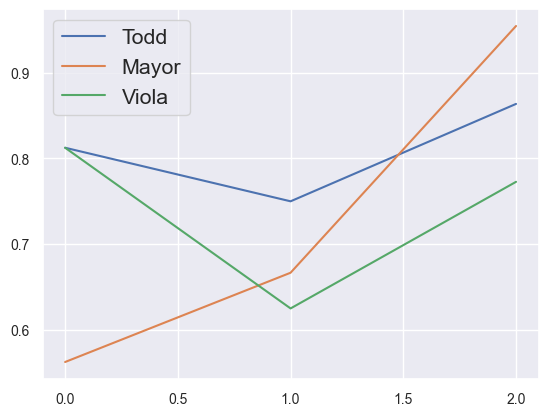

In [14]:
## Plotting Characters importance/significance throughout the series
degree_evol_df[['Todd', 'Mayor', 'Viola']].plot(fontsize = 10)
plt.savefig('progression.png')